# Image Generation

An autoencoder is a neural network trained to reproduce its input at the output. It consists of three main parts internally:
1. An encoder network that obtains a vector $\mathbf{h}$, of smaller dimensionality than the input.
$$
\mathbf{h}=f(\mathbf{x})
$$
$\mathbf{h}$ constitutes a latent representation of the input. This latent representation should contain the information of the original input in order to reconstruct it.
2. A decoder network that, from $\mathbf{h}$, produces $\mathbf{\hat{x}}$.
$$
\mathbf{\mathbf{\hat{x}}}=f(\mathbf{h})
$$
The entire autoencoder is trained so that $\mathbf{\hat{x}}$ reproduces $\mathbf{x}$, for which the vector $\mathbf{h}$ must contain the information contained in $\mathbf{x}$, despite being of much smaller dimensionality.

![Architecture diagram of an autoencoder](https://miro.medium.com/v2/resize:fit:600/0*83pAHsVsnsqySOHN.png)

## Task to be performed
Design a convolutional autoencoder capable of reconstructing images and, in the process, learning to represent the original images in a reduced-dimensional latent space.

### Preparations
We will use the MNIST dataset, from which we only need the inputs (we discard the labels). Additionally, we can utilize both the training and test sets for training purposes.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Set a fixed seed for numpy (for numpy operations)
np.random.seed(0)

# Set a fixed seed for TensorFlow (for TensorFlow operations)
tf.random.set_seed(0)

# Load the MNIST dataset and preprocess it
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

2024-03-23 14:49:08.752535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 14:49:08.977743: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-23 14:49:09.768065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/bruno/anaconda3/envs/tf-gpu/lib/
2024-03-23 14:49:09.768275: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plu

In [3]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

# Input layer
input_img = Input(shape=(28, 28, 1))  # Input size (image size)
dimension_h = 2  # Output size of encoder / input size of decoder

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Flatten()(x)  # Reduce to 1 dimension
latent_vector = Dense(dimension_h)(x)

# Define the encoder model
encoder = Model(input_img, latent_vector)
encoder.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 8)         2312      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 392)               0   

In [4]:
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras.models import Model

# Decoder
latent_input = Input(shape=(dimension_h,))

x = Dense(7 * 7 * 8, activation='relu')(latent_input)
x = Reshape((7, 7, 8))(x)

x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded_output = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)  # Output dimension reduction to one dimension (28, 28, 1)

# Define the decoder model
decoder = Model(latent_input, decoded_output)
decoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 392)               1176      
                                                                 
 reshape (Reshape)           (None, 7, 7, 8)           0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 8)          584       
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 32)       2336

  - Diseña el modelo del autoencoder completo concatenando el encoder y el decoder.
  - Compila el modelo indicando un optimizador y función de pérdida que consideres apropiados.

In [5]:
encoder_input = Input(shape=(28, 28, 1)) # Input encoder
encoded = encoder(encoder_input)        # Output encoder
decoded = decoder(encoded)              # Output decoder
autoencoder = Model(encoder_input, decoded) # Model
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model_1 (Functional)        (None, 2)                 3418      
                                                                 
 model_2 (Functional)        (None, 28, 28, 1)         4385      
                                                                 
Total params: 7,803
Trainable params: 7,803
Non-trainable params: 0
_________________________________________________________________


In [6]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [7]:
# import the time module
import time

# get the current time in seconds since the epoch
start = time.time()
autoencoder.fit(mnist_digits,mnist_digits, epochs=30, batch_size=128)
end = time.time()

print('Time: ', end-start)

2024-03-23 14:49:24.187264: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 219520000 exceeds 10% of free system memory.
2024-03-23 14:49:24.545207: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 219520000 exceeds 10% of free system memory.
2024-03-23 14:49:24.894261: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 219520000 exceeds 10% of free system memory.
2024-03-23 14:49:25.064900: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 219520000 exceeds 10% of free system memory.


Epoch 1/30


2024-03-23 14:49:27.137078: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-03-23 14:49:28.861943: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-23 14:49:30.078671: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


547/547 [==============================] - 9s 7ms/step - loss: 0.0696
Epoch 2/30
547/547 [==============================] - 3s 6ms/step - loss: 0.0521
Epoch 3/30
547/547 [==============================] - 4s 7ms/step - loss: 0.0504
Epoch 4/30
547/547 [==============================] - 3s 6ms/step - loss: 0.0493
Epoch 5/30
547/547 [==============================] - 3s 6ms/step - loss: 0.0486
Epoch 6/30
547/547 [==============================] - 3s 6ms/step - loss: 0.0479
Epoch 7/30
547/547 [==============================] - 3s 6ms/step - loss: 0.0474
Epoch 8/30
547/547 [==============================] - 4s 6ms/step - loss: 0.0469
Epoch 9/30
547/547 [==============================] - 3s 6ms/step - loss: 0.0465
Epoch 10/30
547/547 [==============================] - 3s 6ms/step - loss: 0.0462
Epoch 11/30
547/547 [==============================] - 3s 6ms/step - loss: 0.0459
Epoch 12/30
547/547 [==============================] - 4s 6ms/step - loss: 0.0457
Epoch 13/30
547/547 [===============

In [9]:
import matplotlib.pyplot as plt

'''
This function creates a grid of nxn images where each one is the result of applying the decoder passed as a parameter to a vector [x,y], where x and y traverse the space between -1 and
1 using increments to cover it uniformly.
'''
def generate_image_grid(decoder, image_shape, exploration_limits=[-1,1], scale=15, steps=30):
    image_height = image_shape[0]
    image_width = image_shape[1]

    # We will have only one array where we will store the generated images
    general_image = np.zeros((image_height * steps, image_width * steps))

    h = []

    for i in range(steps):
        for j in range(steps):
            # Calculate the value h to pass to the decoder
            h0 = exploration_limits[0] + (exploration_limits[1]-exploration_limits[0])*i/steps
            h1 = exploration_limits[0] + (exploration_limits[1]-exploration_limits[0])*j/steps
            h.append([h0, h1])

    h = np.array(h)
    # Generate the image from the h values
    generated_image = decoder.predict(h, verbose=0).reshape(-1, image_height, image_width)

    c = 0
    for i in range(steps):
        for j in range(steps):
            # Save the image in the general image
            general_image[i * image_height : (i+1) * image_height, j * image_width : (j+1) * image_width] = generated_image[c]
            c+=1

    # Show a plot with the general image
    plt.figure(figsize=(scale, scale))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.xlabel("h0")
    plt.ylabel("h1")
    plt.imshow(general_image, cmap="Greys_r")
    plt.show()


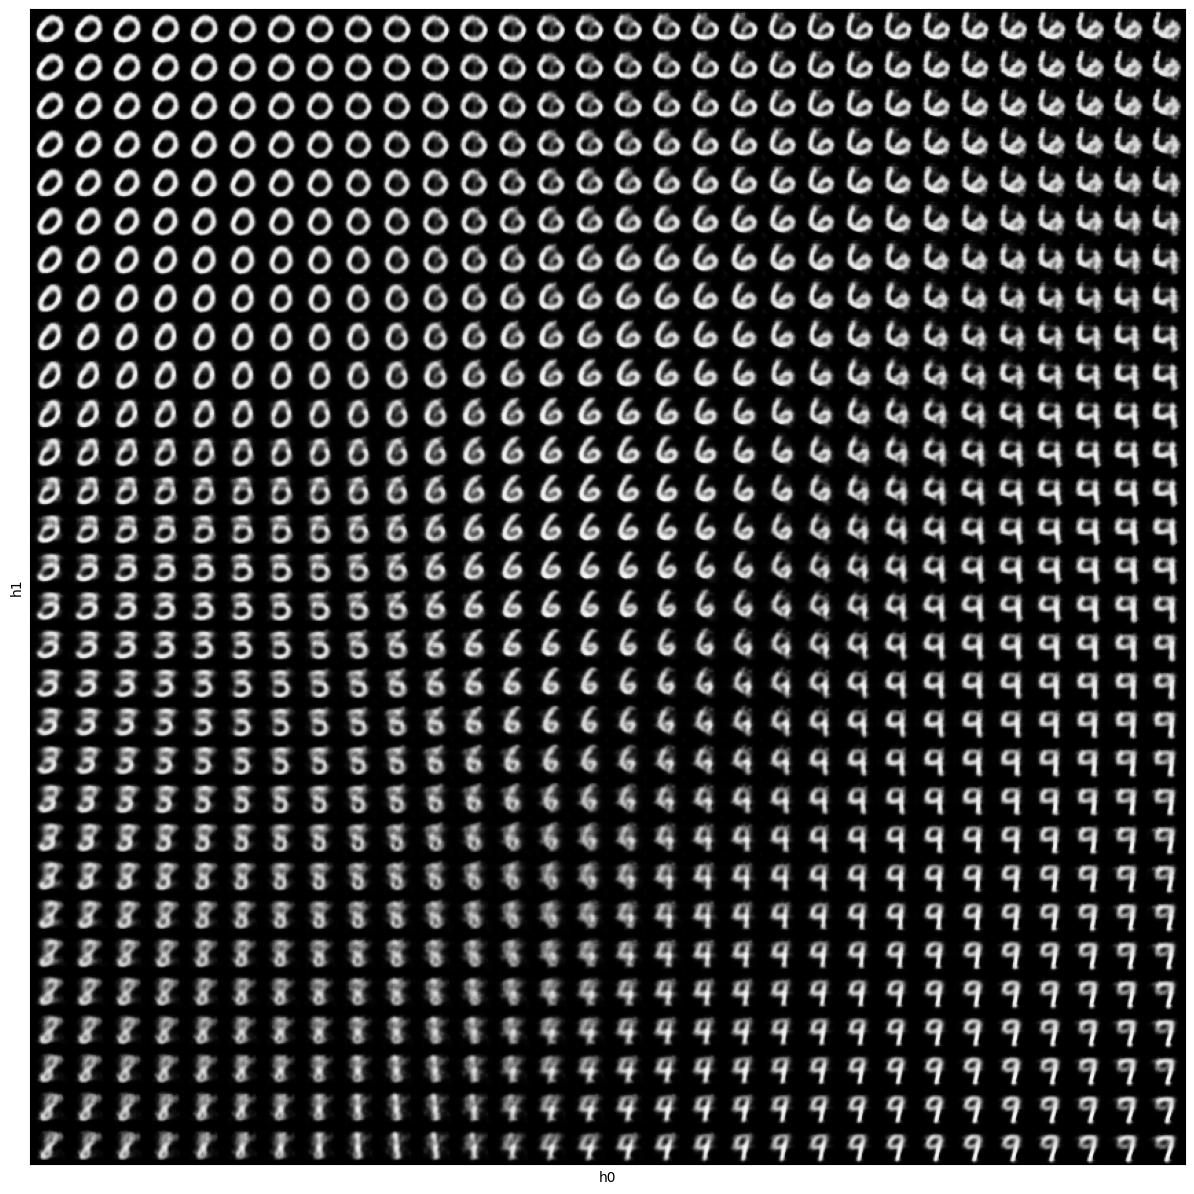

In [12]:
generate_image_grid(decoder, (28,28), exploration_limits=[-2.5,2.5], steps=30)

  - Lanza la función para que explore el espacio con tu decoder.

## Improving the Explorability of the Latent Space

Design a new autoencoder with an additional constraint: **each latent variable $h_i$ must follow a Gaussian distribution**.

To achieve this, for each latent variable, the encoder will produce two scalars, $hm_i$ and $hs_i$, which will act as the mean and standard deviation of that latent variable. With these parameters, a random sample will be taken from each distribution to obtain the latent vector used as input to the decoder.

$$h_i \sim N(hm_i, hs_i)$$

Use the function `tf.keras.backend.random_normal`, which samples numbers $z \sim N(0, 1)$ from which you can generate $h_i$ as $h_i=hm_i + z*hs_i$

Note: For numerical stability reasons, it may be convenient to take $hs_i$ as the logarithm of the variance instead of the standard deviation. In that case, you can generate $h_i$ like this: $$h_i=hm_i + z*e^{(hs_i/2)}$$

![Architecture diagram of an autoencoder](https://drive.google.com/uc?export=view&id=1i7ADJ0ilUk-lqYa_Qv9_b2sIVJkx_aaS)

## Steps to Follow

### Designing the Architecture
  - Design a new encoder. It should also have some convolutional layers, but now the outputs of this autoencoder will be 2 * latent_dimension scalar values.

In [13]:
from tensorflow.keras import backend as B

class Sample(tf.keras.layers.Layer):
    """Generates a new vector of the same size with the mean of hm values and the standard deviation of hs values"""

    def call(self, inputs):
        hm, hs = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(hm))
        return hm + tf.exp(0.5 * hs) * epsilon

In [14]:

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dense, Reshape, Flatten
from tensorflow.keras.models import Model

# Input layer
input_img = Input(shape=(28, 28, 1))
dimension_h = 2

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Flatten()(x)
hm = Dense(dimension_h, name='hm')(x)  # mean
hs = Dense(dimension_h, name='hs')(x)  # standard deviation

h = Sample(name='h')([hm, hs])  # Latent variable with mean hm and standard deviation hs

# Define the improved encoder model with multiple outputs: hm, hs, and h
improved_encoder = Model(input_img, outputs=[hm, hs, h], name='improved_encoder')

# Decoder
latent_input = Input(shape=(dimension_h,))  # The input of the decoder is h

x = Dense(7 * 7 * 8, activation='relu')(latent_input)
x = Reshape((7, 7, 8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Define the improved decoder model
improved_decoder = Model(latent_input, decoded_output, name='improved_decoder')

- Design the complete model and modify the train_step function to incorporate the KL-divergence in addition to the reconstruction error as part of the loss function. 

- The formula for the KL-divergence between two distributions $p=N(\mu_1,\sigma_1)$ and $q=N(\mu_2,\sigma_2)$ is as follows:
$$KL(p,q) = \log{\frac{\sigma_2}{\sigma_1}}+\frac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\frac{1}{2}$$

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D
from tensorflow.keras.models import Model

class AutoEncoder(keras.Model):
    def __init__(self, encoder, decoder, alpha=0.01, **kwargs):
        super(AutoEncoder, self).__init__(**kwargs) 
        self.alpha = alpha
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        with tf.GradientTape() as tape:
            hm, hs, h = self.encoder(data)
            reconstruction = self.decoder(h)

            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=(1,2,3))) / tf.cast(tf.reduce_prod(data.shape[1:]), tf.float32)
            kl_loss = tf.reduce_mean(tf.reduce_sum(-hs + (0.5 * (tf.square(hm)) + tf.square(tf.exp(hs))) - 1/2, axis=-1))

            loss = reconstruction_loss + kl_loss * self.alpha

        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        
        return {'reconstruction_loss': reconstruction_loss, 'kl_divergence': kl_loss, 'total_loss': loss}


In [16]:
autoencoder = AutoEncoder(improved_encoder, improved_decoder, 0.01)
autoencoder.compile(optimizer='adam')

  - Entrena el modelo

In [17]:
autoencoder.fit(mnist_digits, epochs=20, batch_size=128)

Epoch 1/20


2024-03-23 14:54:56.593741: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 219520000 exceeds 10% of free system memory.


547/547 [==============================] - 4s 6ms/step - reconstruction_loss: 0.0771 - kl_divergence: 0.7085 - total_loss: 0.0842
Epoch 2/20
547/547 [==============================] - 3s 6ms/step - reconstruction_loss: 0.0675 - kl_divergence: 0.6937 - total_loss: 0.0744
Epoch 3/20
547/547 [==============================] - 3s 6ms/step - reconstruction_loss: 0.0674 - kl_divergence: 0.6935 - total_loss: 0.0743
Epoch 4/20
547/547 [==============================] - 3s 6ms/step - reconstruction_loss: 0.0674 - kl_divergence: 0.6939 - total_loss: 0.0743
Epoch 5/20
547/547 [==============================] - 3s 6ms/step - reconstruction_loss: 0.0662 - kl_divergence: 0.7826 - total_loss: 0.0740
Epoch 6/20
547/547 [==============================] - 3s 6ms/step - reconstruction_loss: 0.0650 - kl_divergence: 0.8705 - total_loss: 0.0737
Epoch 7/20
547/547 [==============================] - 3s 5ms/step - reconstruction_loss: 0.0643 - kl_divergence: 0.9235 - total_loss: 0.0735
Epoch 8/20
547/547 [====

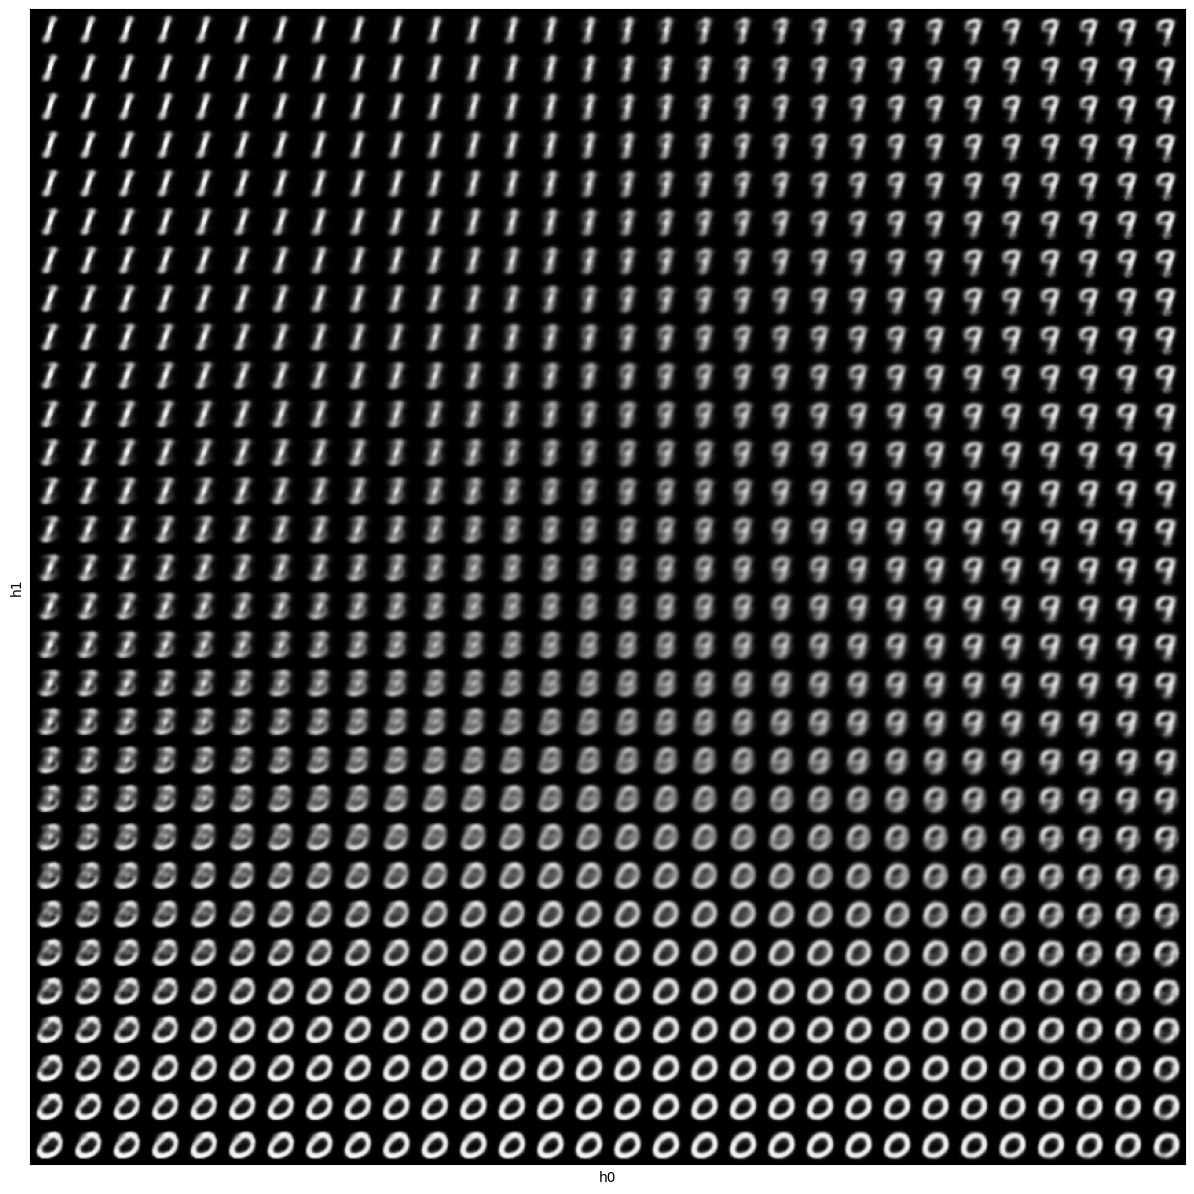

In [18]:
generate_image_grid(autoencoder.decoder, (28,28), exploration_limits=[-4,4], steps=30)

Test with CIFAR10 dataset.

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Load the CIFAR-10 dataset
(train_images, _), (test_images, _) = keras.datasets.cifar10.load_data()

# Concatenate the training and test images
cifar10_digits = tf.concat([train_images, test_images], axis=0)
cifar10_digits = tf.cast(cifar10_digits, tf.float32) / 255.0

# Check the shape of the complete dataset
print("Shape of the complete dataset:", cifar10_digits.shape)

170498071/170498071 [==============================] - 41s 0us/step
Shape of the complete dataset: (60000, 32, 32, 3)


In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dense, Reshape, Flatten, BatchNormalization
from tensorflow.keras.models import Model

# Input layer
input_img = Input(shape=(32, 32, 3))
dimension_h = 512 # Latent dimension

# Encoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dense(64)(x)
x = Dense(64)(x)
x = Dense(32)(x)
x = Dense(32)(x)

x = Flatten()(x)
hm = Dense(dimension_h, name='hm')(x)
hs = Dense(dimension_h, name='hs')(x)

h = Sample()([hm, hs])  # Utilizes the custom 'Sample' layer

encoder_cifar = Model(input_img, outputs=[hm, hs, h], name='encoder_cifar')
encoder_cifar.summary()

# Decoder
latent_input = Input(shape=(dimension_h,))
x = Dense(8 * 8 * 64, activation='relu')(latent_input)  # Adjust dimensions according to your architecture
x = Reshape((8, 8, 64))(x)
x = Dense(32)(x)
x = Dense(32)(x)
x = Dense(64)(x)
x = Dense(64)(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)

decoded = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

decoder_cifar = Model(latent_input, decoded, name='decoder_cifar')


Model: "encoder_cifar"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 128)  3584        ['input_7[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 128)  512        ['conv2d_9[0][0]']               
 alization)                                                                                       
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 16, 16, 128)  0          ['batch_normalization

In [21]:
autoencoder_cifar = AutoEncoder(encoder_cifar, decoder_cifar, 0.00001)
autoencoder_cifar.compile(optimizer='adam')

In [24]:
autoencoder_cifar.fit(cifar10_digits, epochs=20, batch_size=512)

Epoch 1/20


2024-03-23 14:59:44.731412: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-23 14:59:44.731502: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


118/118 [==============================] - 17s 121ms/step - reconstruction_loss: 0.0099 - kl_divergence: 397.1528 - total_loss: 0.0138
Epoch 2/20
118/118 [==============================] - 14s 122ms/step - reconstruction_loss: 0.0094 - kl_divergence: 393.0522 - total_loss: 0.0133
Epoch 3/20
118/118 [==============================] - 14s 122ms/step - reconstruction_loss: 0.0089 - kl_divergence: 389.7112 - total_loss: 0.0128
Epoch 4/20
118/118 [==============================] - 15s 123ms/step - reconstruction_loss: 0.0084 - kl_divergence: 388.5665 - total_loss: 0.0123
Epoch 5/20
118/118 [==============================] - 15s 123ms/step - reconstruction_loss: 0.0080 - kl_divergence: 389.0757 - total_loss: 0.0119
Epoch 6/20
118/118 [==============================] - 15s 124ms/step - reconstruction_loss: 0.0077 - kl_divergence: 390.6521 - total_loss: 0.0117
Epoch 7/20
118/118 [==============================] - 15s 124ms/step - reconstruction_loss: 0.0134 - kl_divergence: 402.2095 - total_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


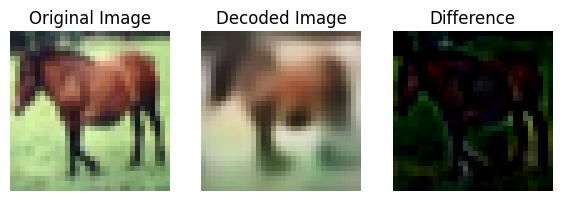

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


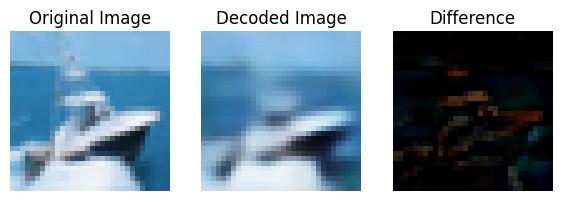

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


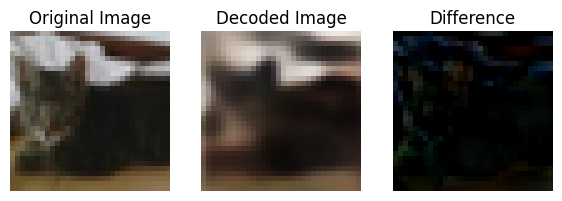

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


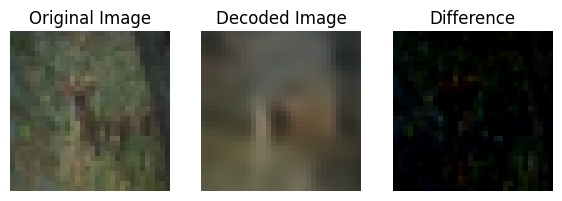

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


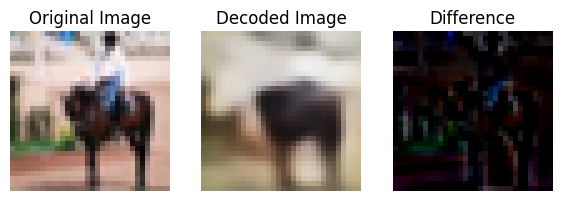

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


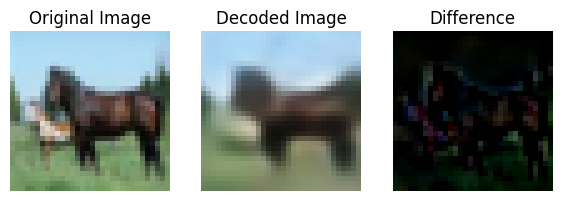

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


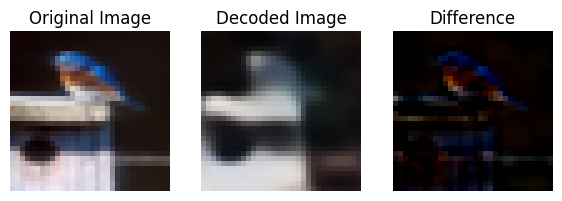

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


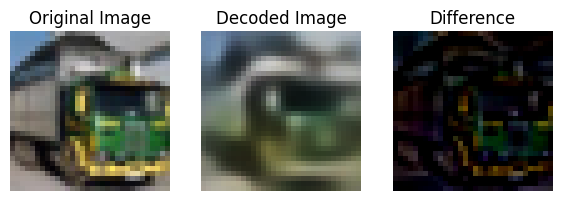

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


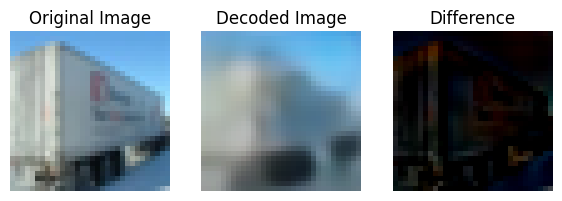

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


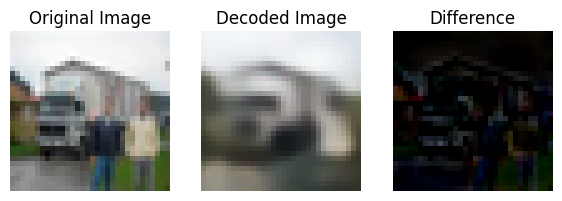

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


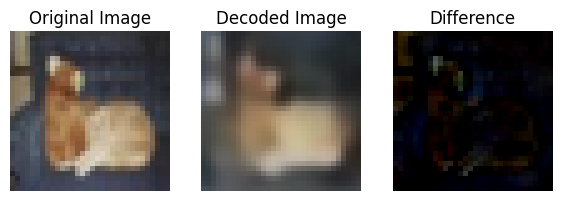

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


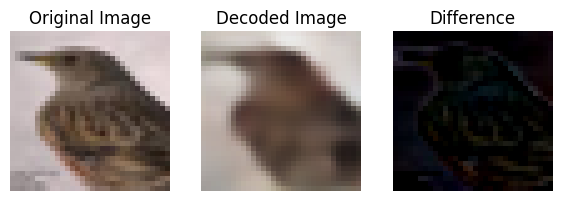

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


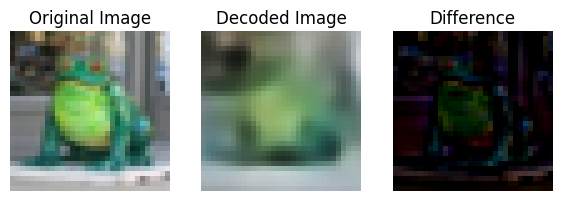

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


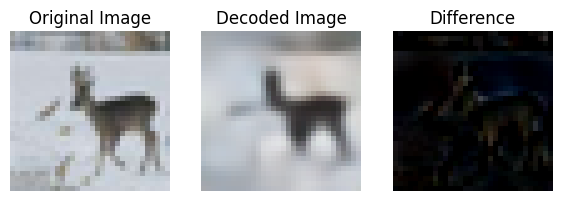

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


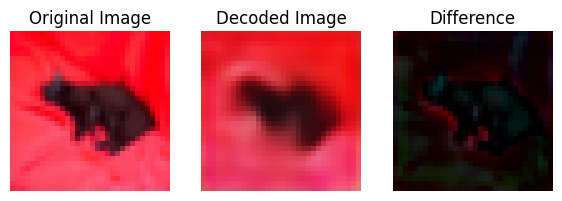

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


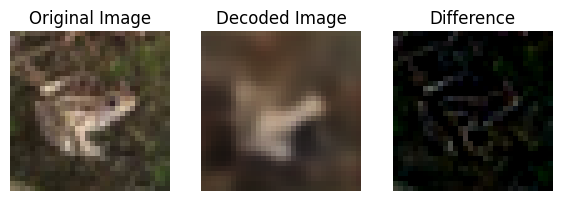

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


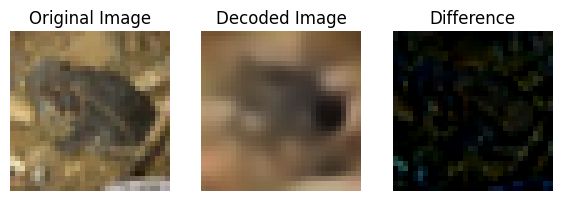

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


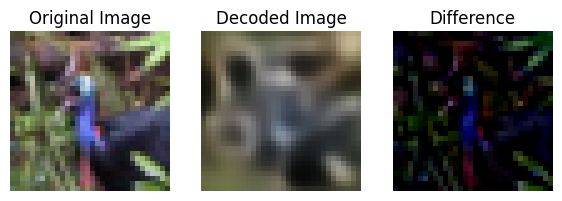

In [25]:
import matplotlib.pyplot as plt

for original_image in cifar10_digits[7:25]:
    hm, hs, h = autoencoder_cifar.encoder.predict(np.array([original_image]), verbose=0)
    decoded_image = autoencoder_cifar.decoder.predict(h, verbose=0)[0]

    # Calculate the difference between the original and decoded image
    difference = original_image - decoded_image

    # Visualize the original image, decoded image, and difference
    plt.figure(figsize=(7, 3))
    plt.subplot(131)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')
    plt.subplot(132)
    plt.title("Decoded Image")
    plt.imshow(decoded_image)
    plt.axis('off')
    plt.subplot(133)
    plt.title("Difference")
    plt.imshow(difference)
    plt.axis('off')
    plt.show()
